# MRI Image Enhancer #
Evan Petrimoulx\
March 20th 2025\
Introduction to MRI

Help from https://www.tensorflow.org/tutorials/images/cnn
#### Import Libraries ####

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

from numpy.fft import ifft2, fftshift
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

#### Load the dataset ####

In [2]:
MRI_Dataset = pd.read_parquet('MRI_kspace.parquet', engine='pyarrow')
MRI_Dataset.describe()

,"(0,0,Re)","(0,1,Re)","(0,2,Re)","(0,3,Re)","(0,4,Re)","(0,5,Re)","(0,6,Re)","(0,7,Re)","(0,8,Re)","(0,9,Re)",...,"(255,140,Im)","(255,141,Im)","(255,142,Im)","(255,143,Im)","(255,144,Im)","(255,145,Im)","(255,146,Im)","(255,147,Im)","(255,148,Im)","(255,149,Im)"
count,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,2905.000000,...,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000
mean,-52.263553,-19.801491,44.915779,18.085327,-27.745068,23.620103,-53.048192,2.039575,12.709563,22.856542,...,-32.974343,4.737096,-39.353739,-5.516731,20.343620,23.730978,-8.244045,-45.079585,37.238409,55.553440
std,1873.511677,1155.255812,1430.323730,1393.707629,1355.440502,1404.989946,1470.575747,1496.964888,1507.456747,1582.526359,...,924.817112,901.973750,948.232841,908.597219,944.599986,941.101881,972.353650,902.345809,1032.182689,864.609879
min,-9691.000000,-7642.366525,-10208.947902,-7558.758499,-7427.070089,-10884.851026,-10499.571433,-9626.033812,-11865.151009,-13641.337318,...,-6496.405431,-5280.202964,-4739.703597,-4504.361521,-5448.445083,-5789.525093,-4971.530124,-4768.041222,-5460.646320,-4295.982051
25%,-800.000000,-450.842541,-560.389075,-498.148855,-523.427839,-512.924248,-547.648457,-522.311857,-518.595810,-497.164575,...,-497.570855,-470.069816,-475.017268,-462.404658,-456.817512,-434.324437,-534.930655,-502.368874,-469.474115,-373.491494
50%,-40.000000,24.748684,29.558563,6.583611,-6.082099,4.195345,-37.478971,12.979651,5.829672,17.936151,...,-35.699446,0.581153,-18.471250,-13.430515,25.733670,10.328039,-21.900562,-10.120314,-3.499531,20.288497
75%,697.000000,450.671098,623.761009,475.790884,541.779058,558.976992,466.485653,533.668700,557.081369,545.152069,...,443.465449,462.900025,452.011531,459.010883,481.408875,483.828347,417.219084,417.008773,542.679788,491.959512
max,12130.000000,6315.167944,9154.611065,8984.007932,7244.035296,9658.071452,13035.090798,8940.115837,8116.743486,7609.786040,...,4319.276436,5090.653318,4424.274940,3859.155119,4918.731735,4149.984425,8613.269201,4934.519591,5356.675510,4440.635482


#### Display information about k-space data ####

In [3]:
def get_median(tuberculosis_data, feature_name):
    return np.median(tuberculosis_data[feature_name])

In [4]:
median = []
MRI_Features_list = []

for i in MRI_Dataset.select_dtypes(include = [int, float]).columns:
    MRI_Features_list.append(i)
    median.append(get_median(MRI_Dataset, i))
    
median_df = pd.DataFrame([median], columns = MRI_Features_list, index =['Median'])

display(median_df)

,"(0,0,Re)","(0,1,Re)","(0,2,Re)","(0,3,Re)","(0,4,Re)","(0,5,Re)","(0,6,Re)","(0,7,Re)","(0,8,Re)","(0,9,Re)",...,"(255,140,Im)","(255,141,Im)","(255,142,Im)","(255,143,Im)","(255,144,Im)","(255,145,Im)","(255,146,Im)","(255,147,Im)","(255,148,Im)","(255,149,Im)"
Median,-40.0,24.748684,29.558563,6.583611,-6.082099,4.195345,-37.478971,12.979651,5.829672,17.936151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Find missing values

In [5]:
MRI_Dataset.isnull().sum()

(0,0,Re)          0
(0,1,Re)          0
(0,2,Re)          0
(0,3,Re)          0
(0,4,Re)          0
               ... 
(255,145,Im)    390
(255,146,Im)    390
(255,147,Im)    390
(255,148,Im)    390
(255,149,Im)    390
Length: 76800, dtype: int64

In [6]:
MRI_Dataset.isna().sum()

(0,0,Re)          0
(0,1,Re)          0
(0,2,Re)          0
(0,3,Re)          0
(0,4,Re)          0
               ... 
(255,145,Im)    390
(255,146,Im)    390
(255,147,Im)    390
(255,148,Im)    390
(255,149,Im)    390
Length: 76800, dtype: int64

Now we need to randomly undersample the MRI images. This will be done by prioritizing the low frequency range and randomly removing the higher frequency ranges from some of the images in the dataset. This is effectively undersampling the image and will produce images that are not complete for the neural network to have to learn from. Ideally, there would be a dataset of already undersampled MRI scans, but since this was not something that I could find, artificially creating one at random should model undersampling as best as possible.

We start here with 40% of the images being undersampled

In [7]:
image_size = (256, 150) 
num_pixels = image_size[0] * image_size[1]

num_undersampled_images = int(len(MRI_Dataset))
masked_indices = random.sample(range(len(MRI_Dataset)), num_undersampled_images)

In [8]:
def variable_density_mask(shape, center_fraction=0.1, power=2):
    x, y = np.meshgrid(np.linspace(-1, 1, shape[1]), np.linspace(-1, 1, shape[0]))
    radius = np.sqrt(x**2 + y**2)

    # Create a probability mask that drops high-frequency components more aggressively
    probability = np.exp(-power * radius**2)
    center_mask = 1 / (1 + np.exp((radius - center_fraction) / 0.1))
    probability = np.maximum(probability, center_mask)

    return np.random.rand(*shape) < probability  # Binary mask

Now we copy the dataset and create a new one containing the undersampled images

In [9]:
undersampled_MRI_Dataset = MRI_Dataset.copy(deep=True)
original_copy = MRI_Dataset.copy(deep=True)

for i in masked_indices:
    k_space_flat = undersampled_MRI_Dataset.iloc[i].values
    k_space_real = k_space_flat[:num_pixels].reshape(image_size)
    k_space_imag = k_space_flat[num_pixels:].reshape(image_size)
    
    mask = variable_density_mask(image_size)
    k_space_real *= mask
    k_space_imag *= mask

    undersampled_MRI_Dataset.iloc[i] = pd.Series(np.concatenate([k_space_real.flatten(), k_space_imag.flatten()]))

undersampled_MRI_Dataset.loc[masked_indices].to_parquet("undersampled_MRI.parquet", compression="zstd")

Now we can use these new datasets to train our CNN. We can use the undersampled dataset for our X_train and X_test, and our Y_train and Y_test will be from the fully sampled dataset. Starting with the undersampled set:

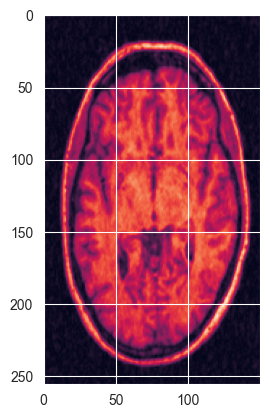

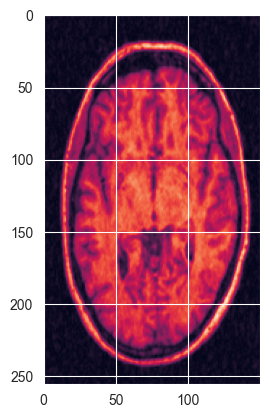

In [10]:
num_images = undersampled_MRI_Dataset.shape[0]
num_pixels = undersampled_MRI_Dataset.shape[1]

real_parts = undersampled_MRI_Dataset.columns[:num_pixels // 2].tolist()
real_parts = undersampled_MRI_Dataset[real_parts].values.reshape(num_images, 256, 150) 

imaginary_parts = undersampled_MRI_Dataset.columns[num_pixels //2 :].tolist()
imaginary_parts = undersampled_MRI_Dataset[imaginary_parts].values.reshape(num_images, 256, 150)  # Extract imaginary components

plt.imshow(np.abs(ifft2(real_parts + 1j * imaginary_parts))[0])
plt.show()
# # Normalize
# real_parts = (real_parts - np.mean(real_parts)) / np.std(real_parts)
# imaginary_parts = (imaginary_parts - np.mean(imaginary_parts)) / np.std(imaginary_parts)
# 
# plt.imshow(np.abs(ifft2(real_parts + 1j * imaginary_parts))[0])
# plt.show()

# Stack real and imaginary as channels with Shape (N, H, W, 2)
X_kspace = np.stack([real_parts, imaginary_parts], axis=-1) 

plt.imshow(np.abs(ifft2(X_kspace[..., 0] + 1j * X_kspace[..., 1]))[0])

Now doing the same for the fully sampled dataset:

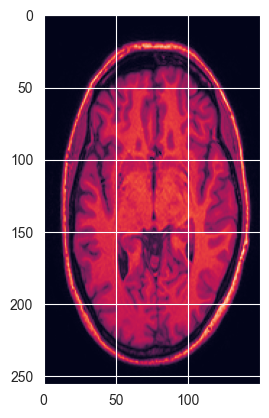

In [11]:
num_images = MRI_Dataset.shape[0]
num_pixels = MRI_Dataset.shape[1]

real_parts = MRI_Dataset.columns[:num_pixels // 2].tolist()
real_parts = MRI_Dataset[real_parts].values.reshape(num_images, 256, 150) 

imaginary_parts = MRI_Dataset.columns[num_pixels //2 :].tolist()
imaginary_parts = MRI_Dataset[imaginary_parts].values.reshape(num_images, 256, 150)  # Extract imaginary components

# Stack real and imaginary as channels with Shape (N, H, W, 2)
Y_kspace = np.stack([real_parts, imaginary_parts], axis=-1) 

plt.imshow(np.abs(ifft2(Y_kspace[..., 0] + 1j * Y_kspace[..., 1]))[0])

In case the missing k-space data is represented as null or NaN:

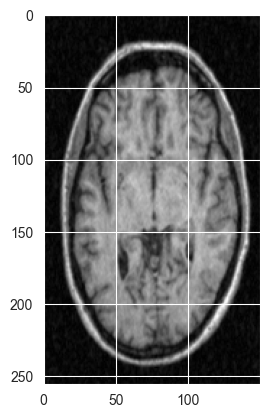

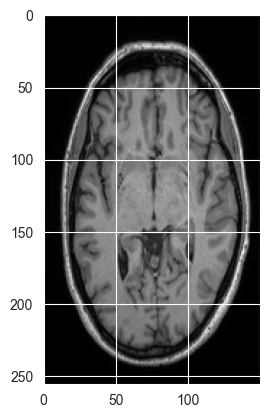

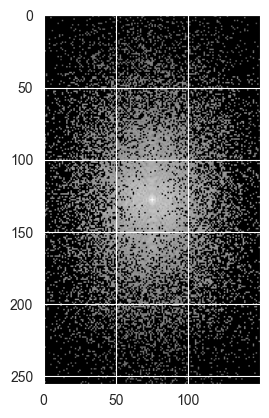

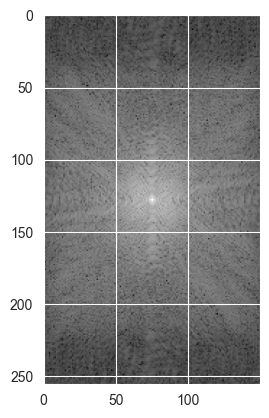

In [12]:
X_kspace = np.nan_to_num(X_kspace)
Y_kspace = np.nan_to_num(Y_kspace)

plt.imshow(np.abs(ifft2(X_kspace[..., 0] + 1j * X_kspace[..., 1]))[0], cmap='grey')
plt.show()
plt.imshow(np.abs(ifft2(Y_kspace[..., 0] + 1j * Y_kspace[..., 1]))[0], cmap='grey')
plt.show()

plt.imshow(np.log1p(np.abs(X_kspace[..., 0] + 1j * X_kspace[..., 1]))[0], cmap='grey')
plt.show()

plt.imshow(np.log1p(np.abs(Y_kspace[..., 0] + 1j * Y_kspace[..., 1]))[0], cmap='grey')
plt.show()

 Now we can use this data to train the convolutional neural network:

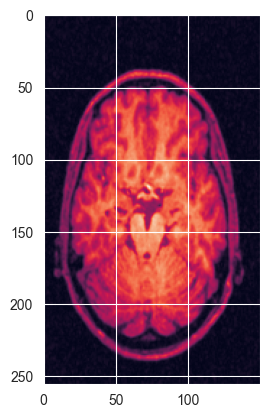

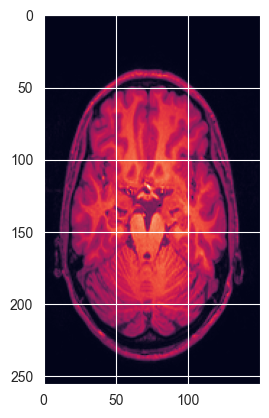

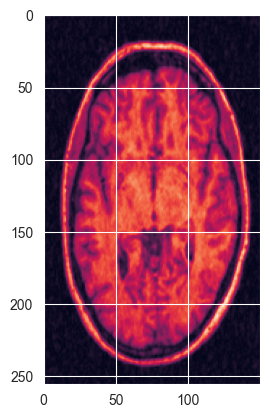

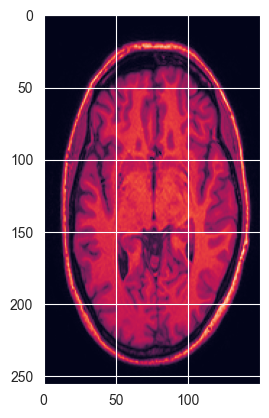

/Users/evanpetrimoulx/.pyenv/versions/3.12.6/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 150, 64)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 75, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 256, 150, 128)  │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 150, 2)    │         2,306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,378 (302.26 KB)

 Trainable params: 77,378 (302.26 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Normalize ...

X_train, X_test, Y_train, Y_test = train_test_split(X_kspace, Y_kspace, random_state=42, train_size=0.7) ## PROBLEM HERE

plt.imshow(np.abs(ifft2(X_train[..., 0] + 1j * X_train[..., 1]))[0])
plt.show()
plt.imshow(np.abs(ifft2(Y_train[..., 0] + 1j * Y_train[..., 1]))[0])
plt.show()

model = models.Sequential()

plt.imshow(np.abs(ifft2(X_kspace[..., 0] + 1j * X_kspace[..., 1]))[0])
plt.show()
plt.imshow(np.abs(ifft2(Y_kspace[..., 0] + 1j * Y_kspace[..., 1]))[0])
plt.show()

# Convolutional Layers
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 150, 2)))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
# model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(layers.MaxPooling2D((2, 2), padding='same'))
# model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(layers.MaxPooling2D((2, 2), padding='same'))

# # Bottleneck
# model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
# 
# # Upsampling layers to reconstruct k-space data
# model.add(layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same'))
model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same'))
# model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))
# model.add(layers.Cropping2D(cropping=((0, 0), (1, 1))))

# Output layer with 2 channels (real & imaginary parts)
model.add(layers.Conv2D(2, (3, 3), activation='linear', padding='same'))  # Linear activation for k-space reconstruction

model.summary()

In [14]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, Y_train,epochs=8,batch_size=8,validation_data=(X_test, Y_test))

Epoch 1/8
255/255 ━━━━━━━━━━━━━━━━━━━━ 113s 441ms/step - loss: 10766782464.0000 - mae: 12655.2744 - val_loss: 6978356736.0000 - val_mae: 10020.5469
Epoch 2/8
255/255 ━━━━━━━━━━━━━━━━━━━━ 119s 466ms/step - loss: 8416058368.0000 - mae: 11034.4326 - val_loss: 6634796032.0000 - val_mae: 9789.3672
Epoch 3/8
255/255 ━━━━━━━━━━━━━━━━━━━━ 131s 515ms/step - loss: 8067243520.0000 - mae: 10886.0957 - val_loss: 6324069376.0000 - val_mae: 9452.8330
Epoch 4/8
255/255 ━━━━━━━━━━━━━━━━━━━━ 125s 491ms/step - loss: 7026091008.0000 - mae: 10336.2871 - val_loss: 6081364480.0000 - val_mae: 9180.2451
Epoch 5/8
255/255 ━━━━━━━━━━━━━━━━━━━━ 129s 504ms/step - loss: 6962866176.0000 - mae: 10103.9170 - val_loss: 5873778176.0000 - val_mae: 8966.1221
Epoch 6/8
255/255 ━━━━━━━━━━━━━━━━━━━━ 129s 506ms/step - loss: 7133970944.0000 - mae: 10007.9619 - val_loss: 5797145088.0000 - val_mae: 8896.7285
Epoch 7/8
255/255 ━━━━━━━━━━━━━━━━━━━━ 131s 514ms/step - loss: 6813904896.0000 - mae: 9973.2529 - val_loss: 5711106560.000

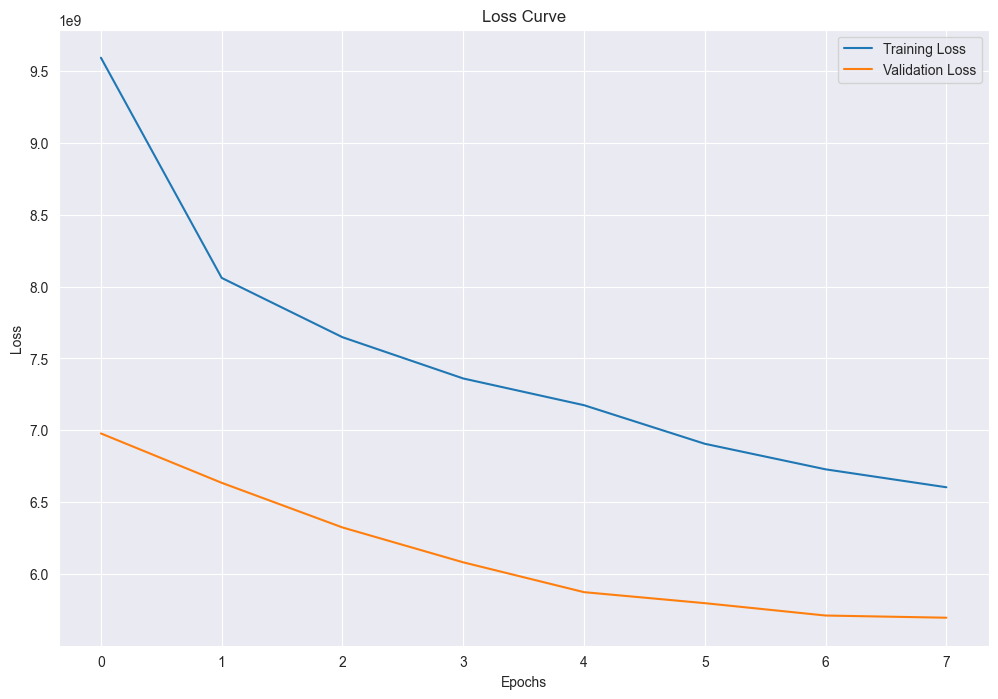

In [15]:
plt.figure(figsize=(12, 8))
sns.lineplot(history.history['loss'], label='Training Loss')
sns.lineplot(history.history.get('val_loss', []), label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

In [16]:
model_loss, model_accuracy = model.evaluate(X_test,  Y_test, verbose=2)
print(model_accuracy)

28/28 - 14s - 510ms/step - loss: 5695847424.0000 - mae: 8841.7373
8841.7373046875


The models accuracy is very high! Lets look at an example to compare the machines prediction with the ground truth image. First we need to recombine the real and imaginary data to retrieve our complex data.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


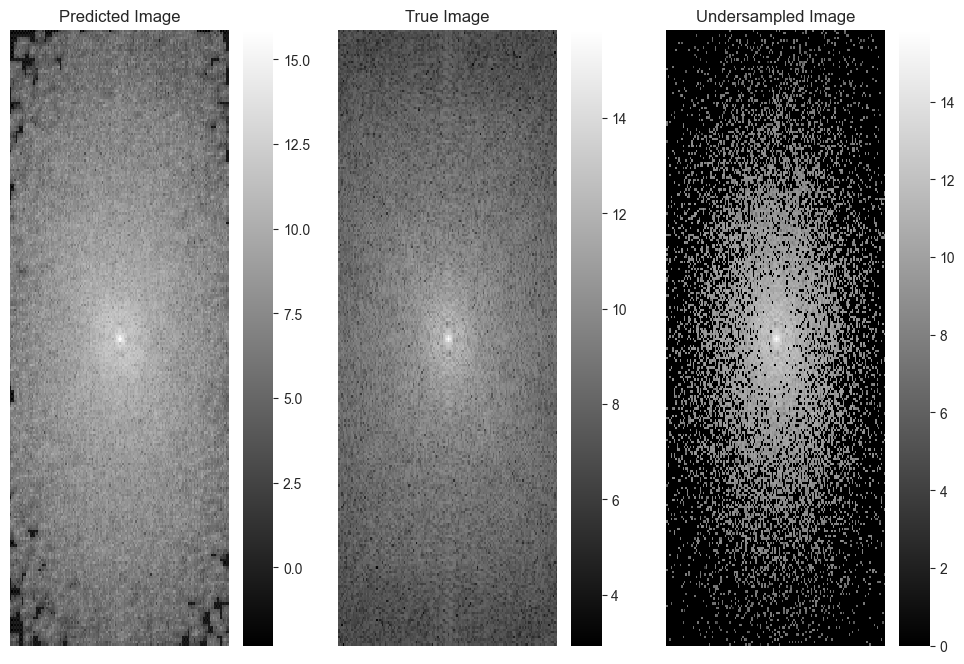

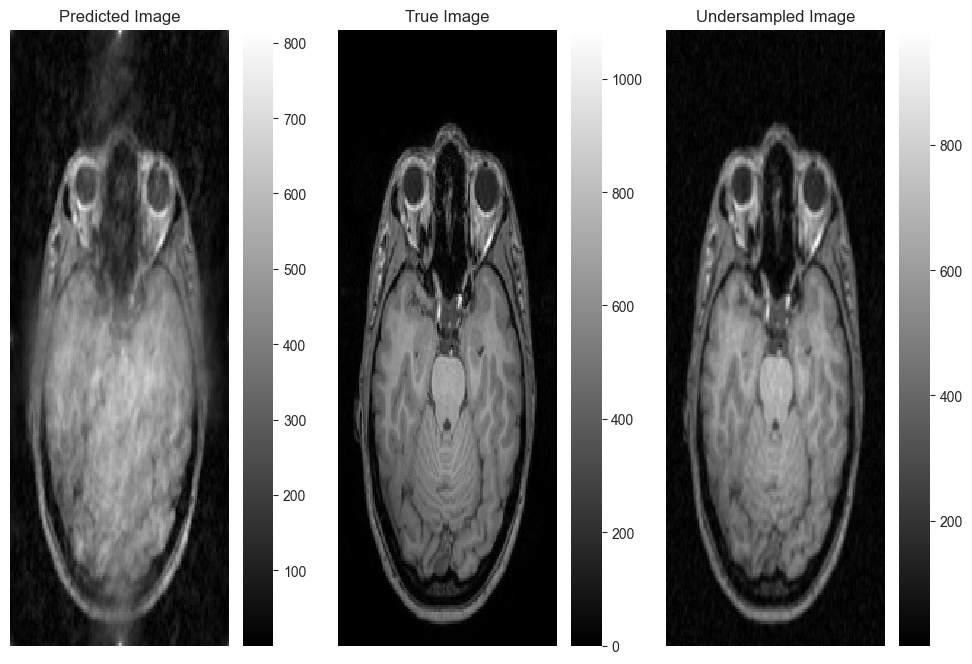

In [23]:
predicted_kspace = model.predict(X_test[15:16])[0]
true_kspace = Y_test[15]
undersampled_kspace = X_test[15]

# Recombine real and complex results
predicted_kspace_complex = predicted_kspace[..., 0] + 1j * predicted_kspace[..., 1]
true_kspace_complex = true_kspace[..., 0] + 1j * true_kspace[..., 1]
undersampled_kspace_complex = undersampled_kspace[..., 0] + 1j * undersampled_kspace[..., 1]

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
sns.heatmap(np.log(np.abs(predicted_kspace_complex)), cmap='gray')
plt.axis('off')
plt.title('Predicted Image')

plt.subplot(1, 3, 2)
sns.heatmap(np.log1p(np.abs(true_kspace_complex)), cmap='gray')
plt.axis('off')
plt.title('True Image')

plt.subplot(1, 3, 3)
sns.heatmap(np.log1p(np.abs(undersampled_kspace_complex)), cmap='gray')
plt.axis('off')
plt.title('Undersampled Image')
plt.show()

predicted_image = ifft2(predicted_kspace_complex)
true_image = ifft2(true_kspace_complex)
undersampled_image = ifft2(undersampled_kspace_complex)

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
sns.heatmap(np.abs(predicted_image), cmap='gray')
plt.axis('off')
plt.title('Predicted Image')

plt.subplot(1, 3, 2)
sns.heatmap(np.abs(true_image), cmap='gray')
plt.axis('off')
plt.title('True Image')

plt.subplot(1, 3, 3)
sns.heatmap(np.abs(undersampled_image), cmap='gray')
plt.axis('off')
plt.title('Undersampled Image')
plt.show()

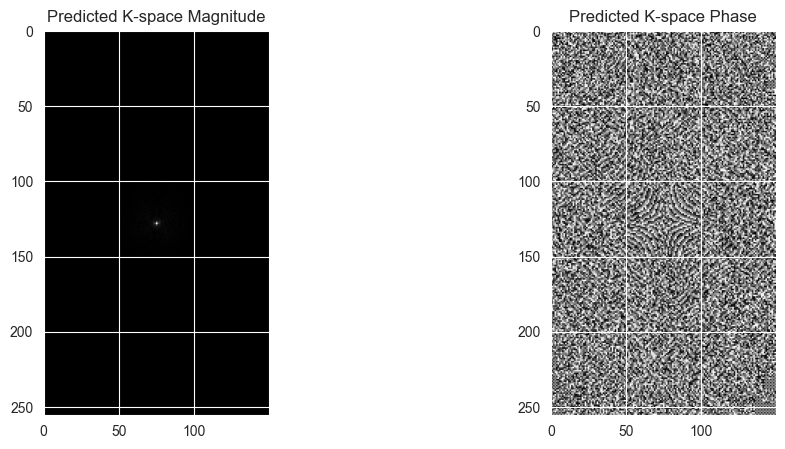

In [18]:
# Check k-space before the inverse FFT
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(np.abs(predicted_kspace_complex), cmap="gray")
plt.title("Predicted K-space Magnitude")

plt.subplot(1,2,2)
plt.imshow(np.angle(predicted_kspace_complex), cmap="gray")
plt.title("Predicted K-space Phase")
plt.show()

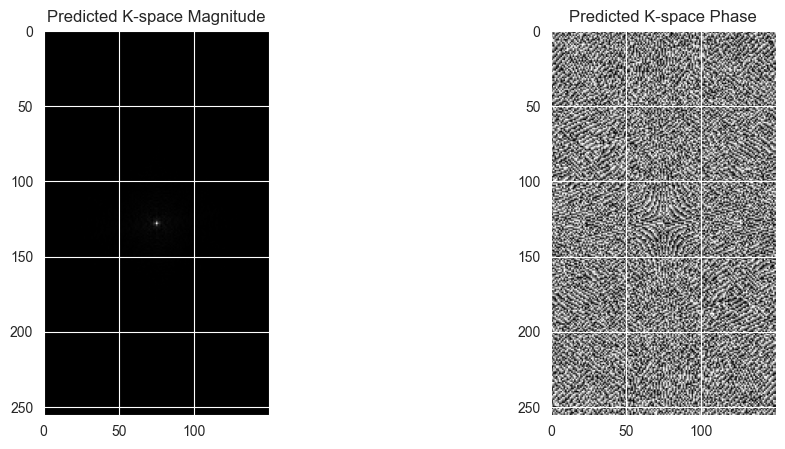

In [19]:
# Check k-space before the inverse FFT
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(np.abs(true_kspace_complex), cmap="gray")
plt.title("Predicted K-space Magnitude")

plt.subplot(1,2,2)
plt.imshow(np.angle(true_kspace_complex), cmap="gray")
plt.title("Predicted K-space Phase")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


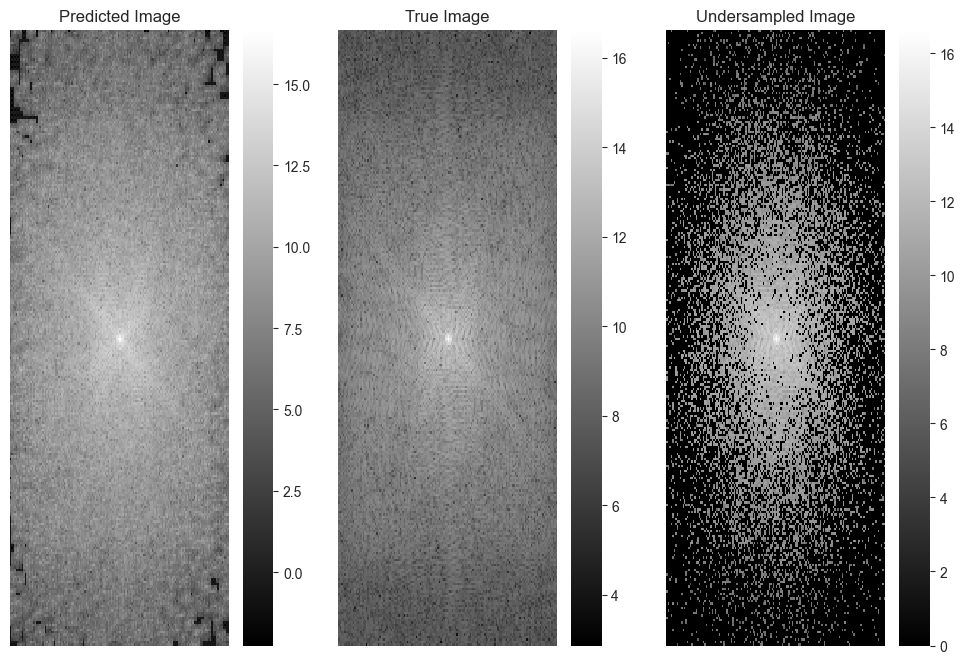

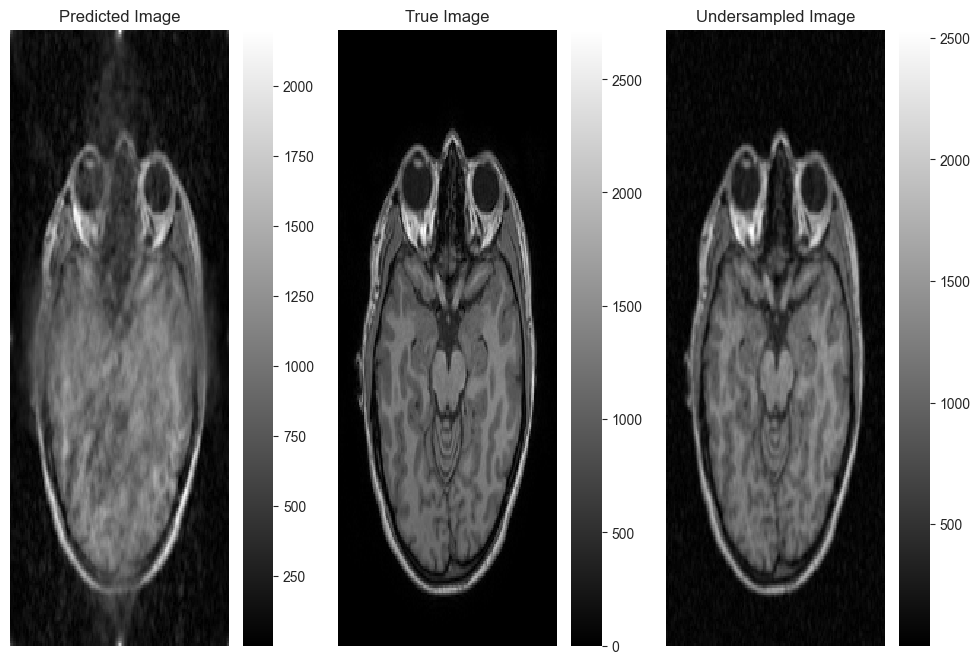

In [20]:
predicted_kspace = model.predict(X_test[34:35])[0]
true_kspace = Y_test[34]
undersampled_kspace = X_test[34]

# Recombine real and complex results
predicted_kspace_complex = predicted_kspace[..., 0] + 1j * predicted_kspace[..., 1]
true_kspace_complex = true_kspace[..., 0] + 1j * true_kspace[..., 1]
undersampled_kspace_complex = undersampled_kspace[..., 0] + 1j * undersampled_kspace[..., 1]

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
sns.heatmap(np.log(np.abs(predicted_kspace_complex)), cmap='gray')
plt.axis('off')
plt.title('Predicted Image')

plt.subplot(1, 3, 2)
sns.heatmap(np.log1p(np.abs(true_kspace_complex)), cmap='gray')
plt.axis('off')
plt.title('True Image')

plt.subplot(1, 3, 3)
sns.heatmap(np.log1p(np.abs(undersampled_kspace_complex)), cmap='gray')
plt.axis('off')
plt.title('Undersampled Image')
plt.show()

predicted_image = ifft2(predicted_kspace_complex)
true_image = ifft2(true_kspace_complex)
undersampled_image = ifft2(undersampled_kspace_complex)

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
sns.heatmap(np.abs(predicted_image), cmap='gray')
plt.axis('off')
plt.title('Predicted Image')

plt.subplot(1, 3, 2)
sns.heatmap(np.abs(true_image), cmap='gray')
plt.axis('off')
plt.title('True Image')

plt.subplot(1, 3, 3)
sns.heatmap(np.abs(undersampled_image), cmap='gray')
plt.axis('off')
plt.title('Undersampled Image')
plt.show()